--- INICIANDO EXECUÇÃO COMPLETA E FINAL (v18 - Multi-Modelo) ---

--- FASE 0: CONFIGURAÇÃO ---
Parâmetros definidos.

--- FASE 1: TREINAMENTO EM LARGA ESCALA COM DADOS SIMULADOS ---

Dados de treino e validação carregados e preparados.

--- Treinando com 5000 amostras ---
Treinando LGBM...
[LightGBM] [Info] Number of positive: 2470, number of negative: 2530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494000 -> initscore=-0.024001
[LightGBM] [Info] Start training from score -0.024001
Treinando PPO...
Treinando Detectores Estatísticos...
  - AUC na validação: LGBM: 0.8160, PPO-Rolling-Avg-W18: 0.8621, MSC: 0.7829, TFG: 0.6596

--- Treina

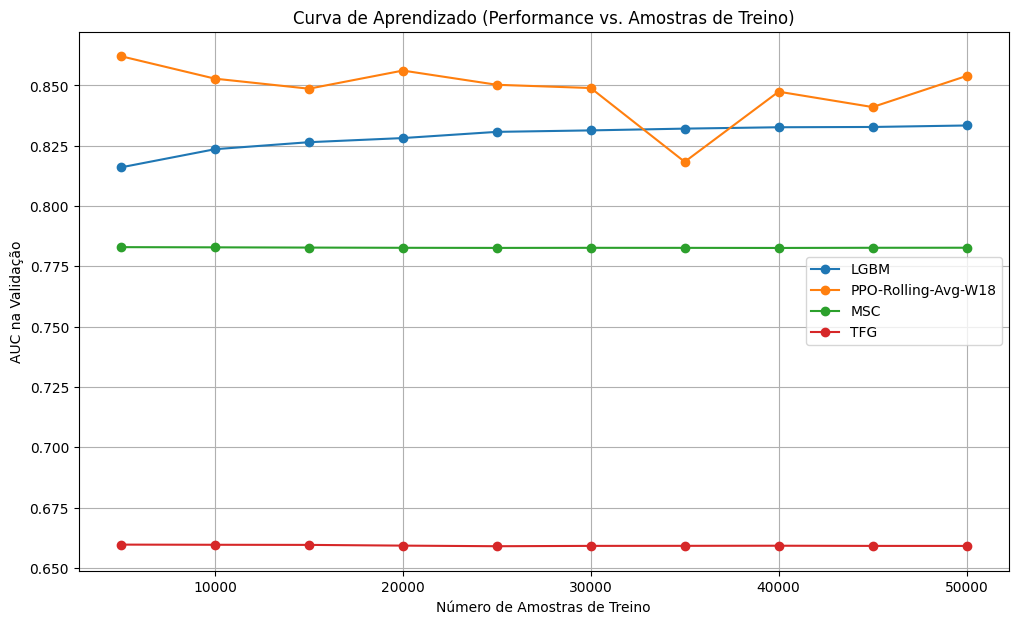


--- FASE 2: COMPARAÇÃO DAS ABORDAGENS DE AJUSTE FINO ---

--- Fold 1/2: Usando 'Ab' para ajuste ---
  Avaliando modelo: LGBM
[LightGBM] [Info] Number of positive: 13032, number of negative: 13032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 3
[LightGBM] [Info] Number of positive: 13032, number of negative: 13032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  Avaliando modelo: PPO-Rolling-Avg-W18


In [ ]:
# -*- coding: utf-8 -*-
"""
CÓDIGO COMPLETO E FINAL (v18 - Multi-Modelo)

Este script consolida todas as fases do experimento para todos os modelos:
1. Carrega e prepara dados simulados em múltiplos formatos ('flat', 'rolling_avg').
2. Treina em Larga Escala: LGBM, PPO, MSC, e TFG.
3. Avalia e Compara Abordagens de Ajuste Fino para todos os modelos aplicáveis.
"""
import numpy as np
import h5py
import lightgbm as lgb
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
import os
import pickle

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


print("--- INICIANDO EXECUÇÃO COMPLETA E FINAL (v18 - Multi-Modelo) ---")

# --- 1. PARÂMETROS E CONFIGURAÇÃO ---
print("\n--- FASE 0: CONFIGURAÇÃO ---")

# Caminhos
SIMULATED_DATA_DIR = '../data/'
TRAIN_DATA_FILE = os.path.join(SIMULATED_DATA_DIR, 'train.hdf5')
EVAL_DATA_FILE = os.path.join(SIMULATED_DATA_DIR, 'eval.hdf5')
EXPERIMENTAL_FEATURES_FILE = './experimental_features.hdf5'
MODELS_DIR = './models'

# Modelos a serem treinados e avaliados
MODELS_TO_TRAIN = ['LGBM', 'PPO-Rolling-Avg-W18', 'MSC', 'TFG']

# Parâmetros de Dados e Treino
NUM_SIGNAL_FREQS = 8
NUM_NOISE_FREQS = 8
SAMPLES_PER_SNR_FULL = 50000
TRAINING_STEPS_FULL = np.arange(5000, SAMPLES_PER_SNR_FULL + 1, 5000)
CHECKPOINTS = [1000, 10000, 25000, 50000]
RANDOM_STATE = 42

# Parâmetros específicos dos modelos
ROLLING_WINDOW_SIZE = 18
RL_TRAINING_EPOCHS = 10
NEGATIVE_REWARD = -5.0

print("Parâmetros definidos.")

# --- 2. CLASSES E FUNÇÕES AUXILIARES ---

# Classe de ambiente para o modelo PPO de Reinforcement Learning
class SignalDetectionEnv(gym.Env):
    def __init__(self, features, labels, negative_reward=-1.0):
        super().__init__()
        self.features, self.labels = features, labels
        self.negative_reward = negative_reward
        self.current_step = 0
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)

    def step(self, action):
        predicted_label = 1 if action[0] > 0 else 0
        reward = 1.0 if predicted_label == self.labels[self.current_step] else self.negative_reward
        self.current_step += 1
        terminated = self.current_step >= len(self.features)
        next_obs = self.features[self.current_step] if not terminated else np.zeros(self.observation_space.shape)
        return next_obs, reward, terminated, False, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return self.features[0], {}

# Classe para os detectores estatísticos (MSC, TFG)
class ORDTester:
    def __init__(self, desired_alpha=0.05):
        self.desired_alpha = desired_alpha
        self.feature_names = ['MSC', 'CSM', 'TFG', 'TFL']
        self.thresholds = {}
    def train(self, noise_features):
        for i, key in enumerate(self.feature_names):
            if noise_features.shape[0] > 0:
                self.thresholds[key] = np.percentile(noise_features[:, i], (1 - self.desired_alpha) * 100)
    def predict(self, features, detector_name):
        if detector_name not in self.feature_names:
            raise ValueError(f"Detector {detector_name} não conhecido.")
        feature_idx = self.feature_names.index(detector_name)
        if detector_name in self.thresholds:
            return (features[:, feature_idx] > self.thresholds[detector_name]).astype(int)
        else:
            return np.zeros(features.shape[0], dtype=int)

# Funções de preparação de dados
def create_rolling_avg_features(trial_data, window_size):
    n_trials, n_steps, n_features = trial_data.shape
    rolling_features = np.zeros_like(trial_data)
    for i in range(n_steps):
        start_idx = max(0, i - window_size + 1)
        rolling_features[:, i, :] = np.mean(trial_data[:, start_idx:i+1, :], axis=1)
    return rolling_features

def load_and_prepare_simulated_data(filepath, trials_per_snr, num_signal_freqs, window_size):
    """Carrega dados simulados e prepara as variantes 'flat' e 'rolling_avg'."""
    if not os.path.exists(filepath): return None
    
    X_sig_trials, X_noise_trials = [], []
    with h5py.File(filepath, 'r') as f:
        snr_levels = [key for key in f.keys() if 'snr' in key]
        for snr in snr_levels:
            metrics_data = f[snr]['metrics'][:trials_per_snr, :, :]
            # Dados são (trials, freqs, features). Cada trial tem num_signal_freqs + num_noise_freqs.
            # No seu notebook, a separação é feita no eixo de frequências.
            total_freqs = metrics_data.shape[1]
            X_sig_trials.append(metrics_data[:, :num_signal_freqs, :])
            X_noise_trials.append(metrics_data[:, num_signal_freqs:num_signal_freqs*2, :]) # Assume igual número de freqs de ruído

    X_sig = np.vstack(X_sig_trials)
    X_noise = np.vstack(X_noise_trials)
    
    # Dataset 'flat' para LGBM e ORD
    X_flat_sig = X_sig.reshape(-1, X_sig.shape[-1])
    X_flat_noise = X_noise.reshape(-1, X_noise.shape[-1])
    X_train_flat = np.vstack([X_flat_sig, X_flat_noise])
    y_train_flat = np.concatenate([np.ones(len(X_flat_sig)), np.zeros(len(X_flat_noise))])
    p_flat = np.random.permutation(len(X_train_flat))
    X_train_flat, y_train_flat = X_train_flat[p_flat], y_train_flat[p_flat]

    # Dataset 'rolling_avg' para PPO
    X_ordered = np.vstack([X_sig, X_noise])
    # Labels para PPO precisam ter o mesmo shape de X_ordered antes do reshape
    y_ordered_labels = np.vstack([np.ones((len(X_sig), num_signal_freqs)), np.zeros((len(X_noise), num_signal_freqs))])
    p_ord = np.random.permutation(len(X_ordered))
    X_ordered, y_ordered_labels = X_ordered[p_ord], y_ordered_labels[p_ord]
    X_rolling_trials = create_rolling_avg_features(X_ordered, window_size)
    X_train_rolling = X_rolling_trials.reshape(-1, X_rolling_trials.shape[-1])
    y_train_rolling = y_ordered_labels.flatten()
        
    return {
        'flat': (X_train_flat, y_train_flat),
        'rolling_avg': (X_train_rolling, y_train_rolling)
    }

# --- 3. FASE 1: TREINAMENTO EM LARGA ESCALA ---
print("\n--- FASE 1: TREINAMENTO EM LARGA ESCALA COM DADOS SIMULADOS ---")

full_train_datasets = load_and_prepare_simulated_data(TRAIN_DATA_FILE, trials_per_snr=5000, num_signal_freqs=NUM_SIGNAL_FREQS, window_size=ROLLING_WINDOW_SIZE)
val_datasets = load_and_prepare_simulated_data(EVAL_DATA_FILE, trials_per_snr=1000, num_signal_freqs=NUM_SIGNAL_FREQS, window_size=ROLLING_WINDOW_SIZE)

run_full_execution = full_train_datasets is not None and val_datasets is not None

if run_full_execution:
    print("\nDados de treino e validação carregados e preparados.")
    
    performance_history = {model: [] for model in MODELS_TO_TRAIN}
    if not os.path.exists(MODELS_DIR): os.makedirs(MODELS_DIR)

    for n_samples in TRAINING_STEPS_FULL:
        print(f"\n--- Treinando com {n_samples} amostras ---")
        
        # Preparar fatias de dados para cada tipo de modelo
        X_flat_slice = full_train_datasets['flat'][0][:n_samples]
        y_flat_slice = full_train_datasets['flat'][1][:n_samples]
        X_rolling_slice = full_train_datasets['rolling_avg'][0][:n_samples]
        y_rolling_slice = full_train_datasets['rolling_avg'][1][:n_samples]
        
        trained_models = {}

        # Treinar modelos
        if 'LGBM' in MODELS_TO_TRAIN:
            print("Treinando LGBM...")
            model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
            model.fit(X_flat_slice, y_flat_slice)
            trained_models['LGBM'] = model
        
        if 'PPO-Rolling-Avg-W18' in MODELS_TO_TRAIN:
            print("Treinando PPO...")
            env = SignalDetectionEnv(X_rolling_slice, y_rolling_slice, NEGATIVE_REWARD)
            total_timesteps = n_samples * RL_TRAINING_EPOCHS
            model = PPO("MlpPolicy", env, n_steps=min(1024, n_samples), verbose=0)
            model.learn(total_timesteps=total_timesteps)
            trained_models['PPO-Rolling-Avg-W18'] = model

        if 'MSC' in MODELS_TO_TRAIN or 'TFG' in MODELS_TO_TRAIN:
            print("Treinando Detectores Estatísticos...")
            model = ORDTester()
            model.train(X_flat_slice[y_flat_slice == 0]) # Treina apenas com amostras de ruído
            trained_models['MSC'] = model
            trained_models['TFG'] = model
            
        # Avaliar e salvar
        auc_step = {}
        for model_name, model in trained_models.items():
            if model_name == 'LGBM':
                y_pred = model.predict_proba(val_datasets['flat'][0])[:, 1]
                auc = roc_auc_score(val_datasets['flat'][1], y_pred)
            elif model_name == 'PPO-Rolling-Avg-W18':
                y_pred, _ = model.predict(val_datasets['rolling_avg'][0], deterministic=True)
                auc = roc_auc_score(val_datasets['rolling_avg'][1], y_pred)
            elif model_name in ['MSC', 'TFG']:
                y_pred = model.predict(val_datasets['flat'][0], detector_name=model_name)
                auc = roc_auc_score(val_datasets['flat'][1], y_pred)
            
            auc_step[model_name] = auc
            performance_history[model_name].append(auc)

        print("  - AUC na validação:", ", ".join([f"{k}: {v:.4f}" for k, v in auc_step.items()]))

        if n_samples in CHECKPOINTS:
            for model_name, model in trained_models.items():
                model_path = os.path.join(MODELS_DIR, f'{model_name}_{n_samples}_samples.pkl')
                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)
                print(f"  - Modelo salvo: {model_path}")
    
    # Plotar curva de aprendizado
    plt.figure(figsize=(12, 7))
    for model_name, scores in performance_history.items():
        if scores:
            plt.plot(TRAINING_STEPS_FULL, scores, marker='o', linestyle='-', label=model_name)
    plt.title("Curva de Aprendizado (Performance vs. Amostras de Treino)")
    plt.xlabel("Número de Amostras de Treino")
    plt.ylabel("AUC na Validação")
    plt.grid(True)
    plt.legend()
    plt.savefig("learning_curve_final_all_models.png")
    plt.show()

# --- 4. FASE 2: COMPARAÇÃO DAS ABORDAGENS DE AJUSTE FINO ---
print("\n--- FASE 2: COMPARAÇÃO DAS ABORDAGENS DE AJUSTE FINO ---")

with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
    volunteers = list(f.keys())

results = {model: {'baseline_tpr':[], 'baseline_fpr':[], 'finetune_tpr':[], 'finetune_fpr':[], 'retrain_tpr':[], 'retrain_fpr':[]} for model in MODELS_TO_TRAIN}

for i, tune_volunteer in enumerate(volunteers):
    print(f"\n--- Fold {i+1}/{len(volunteers)}: Usando '{tune_volunteer}' para ajuste ---")
    
    # Preparar dados de ajuste (todas as intensidades do voluntário)
    with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
        X_tune_list = [f[tune_volunteer][intensity]['metrics'][:] for intensity in f[tune_volunteer].keys()]
    X_tune_raw = np.vstack(X_tune_list)
    X_tune_flat = X_tune_raw.reshape(-1, X_tune_raw.shape[-1])
    labels_per_window = np.concatenate([np.ones(NUM_SIGNAL_FREQS), np.zeros(NUM_NOISE_FREQS)])
    y_tune_flat = np.tile(labels_per_window, X_tune_raw.shape[0]).astype(int)

    # Preparar dados de teste (todos os outros voluntários)
    X_test_list = []
    test_volunteers = [v for v in volunteers if v != tune_volunteer]
    with h5py.File(EXPERIMENTAL_FEATURES_FILE, 'r') as f:
        for test_v in test_volunteers:
            X_test_list.extend([f[test_v][intensity]['metrics'][:] for intensity in f[test_v].keys()])
    X_test_raw = np.vstack(X_test_list)

    # Avaliar cada modelo
    for model_name in MODELS_TO_TRAIN:
        print(f"  Avaliando modelo: {model_name}")
        model_path = os.path.join(MODELS_DIR, f'{model_name}_50000_samples.pkl')
        if not os.path.exists(model_path):
            print(f"    - Modelo base não encontrado. Pulando.")
            continue
        with open(model_path, 'rb') as f:
            base_model = pickle.load(f)
        
        # Função de avaliação genérica
        def evaluate(model, X_raw, model_type, detector_name=None):
            X_flat = X_raw.reshape(-1, X_raw.shape[-1])
            if model_type == 'LGBM':
                preds = model.predict_proba(X_flat)[:, 1]
            elif model_type == 'PPO':
                preds, _ = model.predict(X_flat, deterministic=True)
            elif model_type == 'ORD':
                preds = model.predict(X_flat, detector_name)
            
            preds_reshaped = preds.reshape(X_raw.shape[0], -1)
            tpr = np.mean(preds_reshaped[:, :NUM_SIGNAL_FREQS])
            fpr = np.mean(preds_reshaped[:, NUM_SIGNAL_FREQS:])
            return tpr, fpr

        # Abordagem 1: Baseline
        tpr, fpr = evaluate(base_model, X_test_raw, 'LGBM' if 'LGBM' in model_name else 'PPO' if 'PPO' in model_name else 'ORD', model_name)
        results[model_name]['baseline_tpr'].append(tpr)
        results[model_name]['baseline_fpr'].append(fpr)
        
        # Abordagens de ajuste/retreino
        if 'LGBM' in model_name:
            ft_model = lgb.LGBMClassifier(random_state=RANDOM_STATE).fit(X_tune_flat, y_tune_flat, init_model=base_model)
            re_model = lgb.LGBMClassifier(random_state=RANDOM_STATE).fit(X_tune_flat, y_tune_flat)
        elif 'PPO' in model_name:
            # PPO não suporta 'init_model' diretamente, retreino é a única opção
            env = SignalDetectionEnv(X_tune_flat, y_tune_flat, NEGATIVE_REWARD)
            re_model = PPO("MlpPolicy", env, n_steps=min(1024, len(X_tune_flat)), verbose=0).learn(total_timesteps=len(X_tune_flat)*RL_TRAINING_EPOCHS)
            ft_model = re_model # Trata ajuste e retreino como o mesmo para PPO
        elif model_name in ['MSC', 'TFG']:
            re_model = ORDTester().train(X_tune_flat[y_tune_flat == 0])
            ft_model = re_model # Mesmo para ORD
        
        tpr, fpr = evaluate(ft_model, X_test_raw, 'LGBM' if 'LGBM' in model_name else 'PPO' if 'PPO' in model_name else 'ORD', model_name)
        results[model_name]['finetune_tpr'].append(tpr)
        results[model_name]['finetune_fpr'].append(fpr)
        
        tpr, fpr = evaluate(re_model, X_test_raw, 'LGBM' if 'LGBM' in model_name else 'PPO' if 'PPO' in model_name else 'ORD', model_name)
        results[model_name]['retrain_tpr'].append(tpr)
        results[model_name]['retrain_fpr'].append(fpr)

# Apresentar resultados finais
print("\n--- RESULTADOS FINAIS DO AJUSTE FINO (MÉDIA +/- DESVIO PADRÃO) ---")
for model_name in MODELS_TO_TRAIN:
    print(f"\nResultados para: {model_name}")
    print(f"  Baseline:      TPR = {np.mean(results[model_name]['baseline_tpr']):.4f} +/- {np.std(results[model_name]['baseline_tpr']):.4f} | FPR = {np.mean(results[model_name]['baseline_fpr']):.4f} +/- {np.std(results[model_name]['baseline_fpr']):.4f}")
    print(f"  Ajuste Fino:   TPR = {np.mean(results[model_name]['finetune_tpr']):.4f} +/- {np.std(results[model_name]['finetune_tpr']):.4f} | FPR = {np.mean(results[model_name]['finetune_fpr']):.4f} +/- {np.std(results[model_name]['finetune_fpr']):.4f}")
    print(f"  Retreinamento: TPR = {np.mean(results[model_name]['retrain_tpr']):.4f} +/- {np.std(results[model_name]['retrain_tpr']):.4f} | FPR = {np.mean(results[model_name]['retrain_fpr']):.4f} +/- {np.std(results[model_name]['retrain_fpr']):.4f}")

print("\n--- EXECUÇÃO FINAL CONCLUÍDA ---")